In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install insightface


In [ ]:
pip install --upgrade insightface

In [ ]:
pip install  onnxruntime

In [ ]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(name='buffalo_l',root='/content/drive/My Drive/FaceModel/',providers=['CPUExecutionProvider'])
#['CUDAExecutionProvider', 'CPUExecutionProvider']
app.prepare(ctx_id=0, det_size=(640, 640))

In [ ]:
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/drive/MyDrive/FaceModel/1.jpg')
if img is None:
    print("Image not found or unsupported format.",)
else:
    print("Image loaded successfully!")

cv2_imshow(img)

# Extract the face image from the original image using the bounding box

In [ ]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import matplotlib.pyplot as plt

app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))
#img = ins_get_image('/content/drive/MyDrive/FaceModel/1.jpg')
faces = app.get(img)
cv2_imshow(img)
copy_image= img.copy()

fig, axs = plt.subplots(1, 15, figsize=(12, 5))

# Loop through each face
for i, face in enumerate(faces):
    bbox = face['bbox']
    # Convert the bounding box coordinates to integers
    bbox = [int(b) for b in bbox]
    cv2.rectangle(copy_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Extract the face image from the original image using the bounding box
    face_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1]  # Convert to RGB

    # Display the face in the corresponding subplot
    axs[i].imshow(face_img)
    axs[i].axis('off')  # Hide axis

# Display the plot
plt.show()

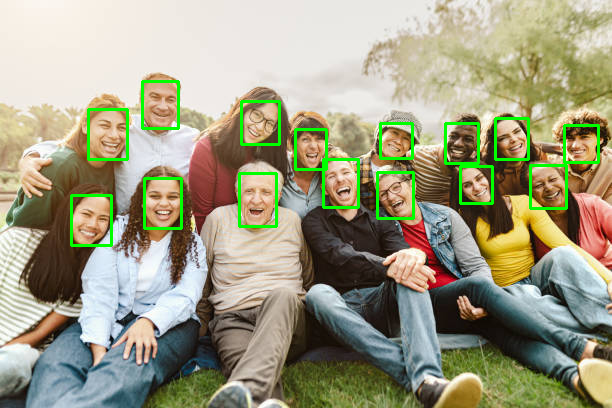

In [37]:
copy_image= img.copy()



# Loop through each face
for i, face in enumerate(faces):
    bbox = face['bbox']
    # Convert the bounding box coordinates to integers
    bbox = [int(b) for b in bbox]
    cv2.rectangle(copy_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)



cv2_imshow(copy_image)

#Recognize Face From Folder

In [ ]:
from glob import glob
import os
from tqdm import tqdm

names = []
embeddings =  []
folders = os.listdir(f'sample_data/pics')
for folder in tqdm(folders):
  if ".ipynb_checkpoints" in folder: continue
  print(folder)
  img_paths = glob(f'sample_data/pics/{folder}/*')
  for img_path in img_paths:
       img = cv2.imread(img_path)
       if img is None: continue
       faces = app.get(img)
       if len(faces) != 1: continue
       face = faces[0]
       names.append(folder)
       embeddings.append(face.normed_embedding)
embeddings = np.stack(embeddings, axis=0)

def recognize_face(input_img, known_embeddings, app):
    # Perform face analysis on the input image
    faces = app.get(input_img)
    # Check if exactly one face is detected
    if len(faces) != 1:
        return "No face or multiple faces detected"
    # Retrieve the embedding for the detected face
    detected_embedding = faces[0].normed_embedding
    # Calculate similarity scores with known embeddings
    scores = np.dot(detected_embedding, np.array(known_embeddings).T)
    scores = np.clip(scores, 0., 1.)
    # Find the index with the highest score
    idx = np.argmax(scores)
    max_score = scores[idx]
    # Check if the maximum score is above a certain threshold (adjust as needed)
    threshold = 0.7
    if max_score >= threshold:
        recognized_name = names[idx]
        return f"Face recognized as {recognized_name} with a confidence score of {max_score:.2f}"
    else:
        return "Face not recognized"
# Assuming 'input_img_path' is the path to the input face image
input_img = cv2.imread("sample_data/pics/vishal/vishal.jpg")
# Call the recognize_face function
result = recognize_face(input_img, embeddings, app)
print(result)

In [ ]:
def detect_person(img, detector):
    bboxes, kpss = detector.detect(img)
    bboxes = np.round(bboxes[:,:4]).astype(np.int)
    kpss = np.round(kpss).astype(np.int)
    kpss[:,:,0] = np.clip(kpss[:,:,0], 0, img.shape[1])
    kpss[:,:,1] = np.clip(kpss[:,:,1], 0, img.shape[0])
    vbboxes = bboxes.copy()
    vbboxes[:,0] = kpss[:, 0, 0]
    vbboxes[:,1] = kpss[:, 0, 1]
    vbboxes[:,2] = kpss[:, 4, 0]
    vbboxes[:,3] = kpss[:, 4, 1]
    return bboxes, vbboxes

In [ ]:
import glob
import matplotlib.pyplot as plt
detector = insightface.model_zoo.get_model('scrfd_person_2.5g.onnx', download=True)
detector.prepare(0, nms_thresh=0.5, input_size=(640, 640))
img_paths = glob.glob('sample_data/pics/vishal/*.jpg')
for img_path in img_paths:
        img = cv2.imread(img_path)
        bboxes, vbboxes = detect_person(img, detector)
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i]
            vbbox = vbboxes[i]
            x1,y1,x2,y2 = bbox
            vx1,vy1,vx2,vy2 = vbbox
            cv2.rectangle(img, (x1,y1)  , (x2,y2) , (0,255,0) , 1)
            alpha = 0.8
            color = (255, 0, 0)
            for c in range(3):
                img[vy1:vy2,vx1:vx2,c] = img[vy1:vy2, vx1:vx2, c]*alpha + color[c]*(1.0-alpha)
            cv2.circle(img, (vx1,vy1) , 1, color , 2)
            cv2.circle(img, (vx1,vy2) , 1, color , 2)
            cv2.circle(img, (vx2,vy1) , 1, color , 2)
            cv2.circle(img, (vx2,vy2) , 1, color , 2)
        filename = img_path.split('/')[-1]
        plt.imshow(img)
        img